In [1]:
import futu as ft
import pandas as pd
import os

In [2]:
# 实例化行情上下文对象
# 如下范例，创建api行情对象，调用get_market_snapshot获取港股腾讯00700的报价快照数据,最后关闭对象
quote_ctx = ft.OpenQuoteContext(host="127.0.0.1", port=11111)
print(quote_ctx.get_market_snapshot('HK.00700'))
quote_ctx.close()

2019-10-06 11:36:52,978 [open_context_base.py] _socket_reconnect_and_wait_ready:256: Start connecting: host=127.0.0.1; port=11111;
2019-10-06 11:36:52,980 [open_context_base.py] on_connected:344: Connected : conn_id=1; 
2019-10-06 11:36:52,983 [open_context_base.py] _handle_init_connect:444: InitConnect ok: conn_id=1; info={'server_version': 205, 'login_user_id': 13529439, 'conn_id': 6586454037681152325, 'conn_key': 'C14B242AD28ED0A2', 'keep_alive_interval': 10, 'is_encrypt': False};


(0,        code          update_time  last_price  open_price  high_price  \
0  HK.00700  2019-10-04 16:08:05       322.8       326.8       327.0   

   low_price  prev_close_price    volume      turnover  turnover_rate  ...  \
0      320.0             325.2  12610140  4.081176e+09          0.132  ...   

   option_theta option_rho  index_valid  index_raise_count  index_fall_count  \
0           NaN        NaN        False                NaN               NaN   

   index_equal_count  plate_valid  plate_raise_count  plate_fall_count  \
0                NaN        False                NaN               NaN   

   plate_equal_count  
0                NaN  

[1 rows x 96 columns])


2019-10-06 11:36:53,040 [network_manager.py] work:366: Close: conn_id=1


In [3]:
#  Get list of all hong kong stock
"""
all_stock_hk_plate = 'HK.BK1910'
quote_ctx = ft.OpenQuoteContext(host="127.0.0.1", port=11111)
stock_list_all_col = quote_ctx.get_plate_stock(all_stock_hk_plate)[1]

# stock_type
#  STOCK：  股票
#  IDX： 指数
#  ETF： 交易所交易基金(Exchange Traded Funds)
#  WARRANT： 港股涡轮牛熊界内证
#  BOND： 债券
#  DRVT： 期权
#  NONE： 未知
stock_list_all_col = stock_list_all_col[stock_list_all_col['stock_type'] == 'STOCK']
stock_list = stock_list_all_col[['code', 'lot_size', 'stock_name', 'stock_type', 'stock_id']]
print(stock_list)
quote_ctx.close()
"""

'\nall_stock_hk_plate = \'HK.BK1910\'\nquote_ctx = ft.OpenQuoteContext(host="127.0.0.1", port=11111)\nstock_list_all_col = quote_ctx.get_plate_stock(all_stock_hk_plate)[1]\n\n# stock_type\n#  STOCK：  股票\n#  IDX： 指数\n#  ETF： 交易所交易基金(Exchange Traded Funds)\n#  WARRANT： 港股涡轮牛熊界内证\n#  BOND： 债券\n#  DRVT： 期权\n#  NONE： 未知\nstock_list_all_col = stock_list_all_col[stock_list_all_col[\'stock_type\'] == \'STOCK\']\nstock_list = stock_list_all_col[[\'code\', \'lot_size\', \'stock_name\', \'stock_type\', \'stock_id\']]\nprint(stock_list)\nquote_ctx.close()\n'

In [4]:
# stock_list.to_csv('stock_hk_list.csv')

In [40]:
import time
# change rate
def get_all_change_list(quote_ctx, codes, start='2019-10-04', end='2019-10-04', max_count=10, page_req_key=None, stock_num=100):
    change_rates = []
    
    stock_cnt = 0
    for code in codes:
        if stock_cnt > stock_num:
            break
        print('{}/{}'.format(stock_cnt, stock_num))
        history_kline = quote_ctx.request_history_kline(code, start=start, end=end, max_count=1000, page_req_key=None)
        # Skip if  ret != RET_OK or data is empty
        if history_kline[0] == -1 or history_kline[1].empty:
            print(history_kline[1])
            continue
        history_kline = history_kline[1][['code', 'change_rate']].values.tolist()[0]
        change_rates.append(history_kline)
        stock_cnt += 1
        time.sleep(3)
    
    change_rates = pd.DataFrame(change_rates, columns=['code', 'change_rate'])
    return change_rates.sort_values(by=['change_rate'], ascending=False)

stock_list = pd.read_csv('stock_hk_list.csv')

quote_ctx = ft.OpenQuoteContext(host="127.0.0.1", port=11111)
change_rates_sorted = get_all_change_list(quote_ctx, stock_list['code'])
print(change_rates_sorted)

quote_ctx.close()

2019-10-06 16:21:28,373 [open_context_base.py] _socket_reconnect_and_wait_ready:256: Start connecting: host=127.0.0.1; port=11111;
2019-10-06 16:21:28,375 [open_context_base.py] on_connected:344: Connected : conn_id=35; 
2019-10-06 16:21:28,380 [open_context_base.py] _handle_init_connect:444: InitConnect ok: conn_id=35; info={'server_version': 205, 'login_user_id': 13529439, 'conn_id': 6586525657078840035, 'conn_key': '2148EB8FD28EDC37', 'keep_alive_interval': 10, 'is_encrypt': False};


0/100
1/100
2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100
11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100
21/100
22/100
Empty DataFrame
Columns: [code, time_key, open, close, high, low, pe_ratio, turnover_rate, volume, turnover, change_rate, last_close]
Index: []
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁

此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触

此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触

此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触

此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触

此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触

此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触发了频率限制，请稍后再试
22/100
此协议请求太频繁，触

2019-10-06 16:22:37,509 [network_manager.py] work:366: Close: conn_id=35


tensorboard 2.0.0 has requirement protobuf>=3.6.0, but you'll have protobuf 3.5.1 which is incompatible.
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


2019-10-06 16:58:24,426 [open_context_base.py] _socket_reconnect_and_wait_ready:256: Start connecting: host=127.0.0.1; port=11111;
2019-10-06 16:58:24,428 [open_context_base.py] on_connected:344: Connected : conn_id=50; 
2019-10-06 16:58:24,432 [open_context_base.py] _handle_init_connect:444: InitConnect ok: conn_id=50; info={'server_version': 205, 'login_user_id': 13529439, 'conn_id': 6586534951875704547, 'conn_key': '54B5209DD28EAC4C', 'keep_alive_interval': 10, 'is_encrypt': False};


(0,         code             time_key   open  close   high    low  pe_ratio  \
0   HK.00022  2019-09-04 00:00:00  0.190  0.190  0.190  0.190     190.0   
1   HK.00022  2019-09-05 00:00:00  0.190  0.190  0.190  0.190     190.0   
2   HK.00022  2019-09-06 00:00:00  0.200  0.200  0.200  0.200     200.0   
3   HK.00022  2019-09-09 00:00:00  0.203  0.203  0.203  0.198     203.0   
4   HK.00022  2019-09-10 00:00:00  0.199  0.196  0.199  0.196     196.0   
5   HK.00022  2019-09-11 00:00:00  0.200  0.195  0.200  0.195     195.0   
6   HK.00022  2019-09-12 00:00:00  0.194  0.194  0.194  0.192     194.0   
7   HK.00022  2019-09-13 00:00:00  0.200  0.200  0.200  0.200     200.0   
8   HK.00022  2019-09-16 00:00:00  0.197  0.199  0.199  0.197     199.0   
9   HK.00022  2019-09-17 00:00:00  0.203  0.200  0.203  0.200     200.0   
10  HK.00022  2019-09-18 00:00:00  0.198  0.197  0.200  0.197     197.0   
11  HK.00022  2019-09-19 00:00:00  0.197  0.198  0.198  0.197     198.0   
12  HK.00022  2019-09

2019-10-06 16:58:24,531 [network_manager.py] work:366: Close: conn_id=50


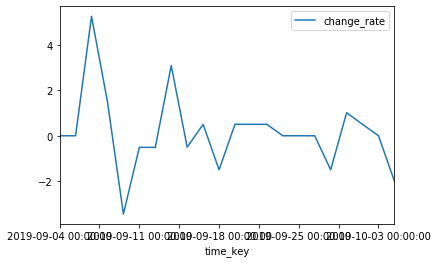

In [55]:
# Draw trend of change rate for one stock
!python3 -mpip install matplotlib
import matplotlib.pyplot as plt

def draw_history_change_rate(quote_ctx, code, start='2019-09-04', end='2019-10-04', max_count=1000):
    history_kline = quote_ctx.request_history_kline(code, start=start, end=end, max_count=max_count)
    if history_kline[0] == -1 or history_kline[1].empty:
        print('No data')
        return
    history_kline_data = history_kline[1][['change_rate', 'time_key']]
    
    history_kline_data.plot(x='time_key', y='change_rate')
    
    #df = history_kline_data.cumsum()
    #plt.figure()
    #df.plot()

quote_ctx = ft.OpenQuoteContext(host="127.0.0.1", port=11111)
draw_history_change_rate(quote_ctx, 'HK.00022')
quote_ctx.close()

In [58]:
# track stock price in real time

columns_name = ['code', 'time', 'is_bank', 'opened_mins', 'cur_price', 'last_close', 'avg_price', 'volume', 'turnover']
code_list = ['HK.00020', 'HK.00021', 'HK.00022']

def track_stock(quote_ctx, code, max_rows=100, max_fail=10):
    
    history_data = pd.DataFrame([], columns=columns_name)
    
    fail_cnt = 0
    while True:
        rt_data = quote_ctx.get_rt_data(code)
        if fail_cnt > max_fail:
            print('No data can be accessable')
            break
        if rt_data[0] < 1 or rt_data[1].empty:
            print('getting data failed')
            fail_cnt += 1
            continue
        history_data = pd.concat([history_data, rt_data[1]])
        
        if history_data.shape[0] > max_rows:
            history_data = pd.DataFrame([], columns=columns_name)

quote_ctx = ft.OpenQuoteContext(host="127.0.0.1", port=11111)
for code in code_list:
    print('{}'.format(code))
    track_stock(quote_ctx, code)

2019-10-06 21:35:55,685 [open_context_base.py] _socket_reconnect_and_wait_ready:256: Start connecting: host=127.0.0.1; port=11111;
2019-10-06 21:35:55,688 [open_context_base.py] on_connected:344: Connected : conn_id=53; 
2019-10-06 21:35:55,692 [open_context_base.py] _handle_init_connect:444: InitConnect ok: conn_id=53; info={'server_version': 205, 'login_user_id': 13529439, 'conn_id': 6586604792330496300, 'conn_key': 'AE846000D38E9C20', 'keep_alive_interval': 10, 'is_encrypt': False};


HK.00020
getting data failed
getting data failed
getting data failed
getting data failed
getting data failed
getting data failed
getting data failed
getting data failed
getting data failed
getting data failed
getting data failed
No data can be accessable
HK.00021
getting data failed
getting data failed
getting data failed
getting data failed
getting data failed
getting data failed
getting data failed
getting data failed
getting data failed
getting data failed
getting data failed
No data can be accessable
HK.00022
getting data failed
getting data failed
getting data failed
getting data failed
getting data failed
getting data failed
getting data failed
getting data failed
getting data failed
getting data failed
getting data failed
No data can be accessable


In [ ]:
# Train a predi